# ======================================================
# **Week 10: From Adaline to MLPs for Text**
# ======================================================


*   **Course:** Predictive Analytics for Text 
*   **Instructor:** Felix P. Muga II, PhD
*   **Version:** Student v1.1
*   **Date:** 10 October 2025

---

## **Learning Objectives**

By the end of this notebook, you should be able to:

1. **Implement `Adaline`, `Perceptron`, and `MLP models`.**  

2. **Understand `gradient descent`, `batch training`, and `non-linear representations`.**  

3. **Connect training behavior to the `Universal Approximation Theorem`.**

---

## **Setup**



In [1]:
## Setup

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim

# Load a small sample dataset (for reproducibility)
texts = ["good product", "bad item", "excellent choice", "poor design", "love it", "hate it", "excellent design", "worst product", "good item"]
labels = [1, 0, 1, 0, 1, 0, 1, 0, 1]
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(texts).toarray()
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=103)


---

## **Understanding Adaline**

**Concept Focus: `Continuous outputs`, `MSE loss`, `smooth convergence`.**

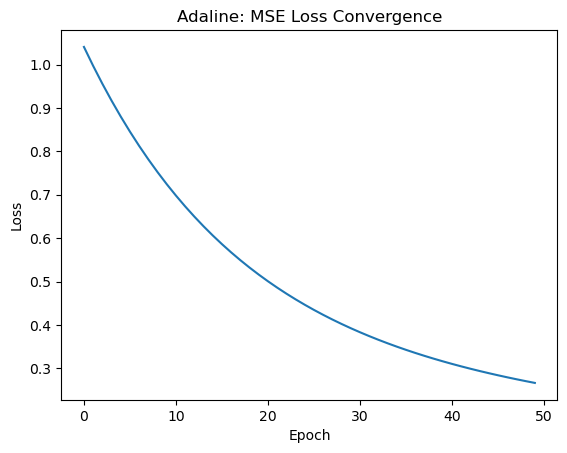

In [2]:
class Adaline(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)
    def forward(self, x):
        return self.linear(x)

adaline = Adaline(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.SGD(adaline.parameters(), lr=0.01)

losses = []
for epoch in range(50):
    optimizer.zero_grad()
    y_pred = adaline(torch.FloatTensor(X_train))
    loss = criterion(y_pred.squeeze(), torch.FloatTensor(y_train))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.title("Adaline: MSE Loss Convergence")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


---
**Reflection Q1**:

*	How does the smooth MSE loss curve relate to continuous outputs?

*	What are the limitations when applying a threshold for binary classification?




---

## **Implementing the Perceptron**

**Concept Focus: `Step activation`, `discrete error correction`, `convergence theorem`.**

In [3]:
class Perceptron:
    def __init__(self, n_features, lr=0.1, n_epochs=20):
        self.w = np.zeros(n_features)
        self.b = 0
        self.lr = lr
        self.n_epochs = n_epochs

    def activation(self, z): return np.where(z >= 0, 1, 0)
    def fit(self, X, y):
        for _ in range(self.n_epochs):
            for xi, yi in zip(X, y):
                y_pred = self.activation(np.dot(xi, self.w) + self.b)
                self.w += self.lr * (yi - y_pred) * xi
                self.b += self.lr * (yi - y_pred)

    def predict(self, X):
        return self.activation(np.dot(X, self.w) + self.b)

perceptron = Perceptron(X_train.shape[1])
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6666666666666666



---

**Reflection Q2:**

*	Why does the perceptron converge only for linearly separable data?

*	Compare its weight update behavior with Adaline’s gradient-based updates.


---

## **Extending to Multi-Layer Perceptron (MLP)**

**Concept Focus: `Non-linear activations`, `mini-batch` vs. `full-batch gradient descent`.**

---

### **Model: MLPText**

In [4]:
class MLPText(nn.Module):
    def __init__(self, n_features, hidden_dim=8):
        super().__init__()
        self.hidden = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        return self.sigmoid(self.output(x))



### **Training Function**

In [5]:

def train_mlp(batch_size):
    model = MLPText(X_train.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=0.05)
    criterion = nn.BCELoss()

    losses = []
    for epoch in range(30):
        perm = torch.randperm(X_train.shape[0])
        for i in range(0, X_train.shape[0], batch_size):
            idx = perm[i:i+batch_size]
            if len(idx) == 0:
                continue  # skip empty mini-batch

            # All of these lines must be indented INSIDE the for-loop
            batch_x = torch.FloatTensor(X_train[idx])
            batch_y = torch.FloatTensor(y_train[idx]).view(-1, 1)

            # Defensive check
            if batch_x.shape[0] == 0 or batch_y.shape[0] == 0:
                continue  # skip again if empty

            optimizer.zero_grad()
            y_pred = model(batch_x)

            # Normalize shapes so BCELoss always receives (N,1)
            y_pred = y_pred.view(-1, 1)
            batch_y = batch_y.view(-1, 1)

            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    return losses, model



### **Mini-batch vs Full-batch Comparison**

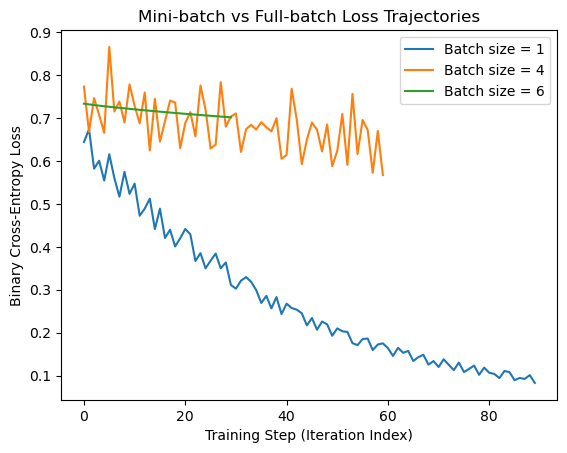

In [6]:

# ---- RUN TRAINING ----
for b in [1, 4, X_train.shape[0]]:  # SGD, Mini-batch, Full-batch
    losses, _ = train_mlp(b)
    plt.plot(losses, label=f"Batch size = {b}")

plt.legend()
plt.xlabel("Training Step (Iteration Index)")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Mini-batch vs Full-batch Loss Trajectories")
plt.show()

**Reflection Q3:** 

Why do smaller batches converge faster but more noisily?

### **Gradient Variance Computation**

In [10]:
def grad_variance(batch_size, repeats=10):
    model = MLPText(X_train.shape[1])
    criterion = nn.BCELoss()
    vars_ = []
    for _ in range(repeats):
        idx = torch.randperm(X_train.shape[0])[:batch_size]
        batch_x = torch.FloatTensor(X_train[idx])
        batch_y = torch.FloatTensor(y_train[idx]).view(-1,1)

        # Defensive check
        if batch_x.shape[0] == 0 or batch_y.shape[0] == 0:
            continue  # skip again if empty

        y_pred = model(batch_x)
        # ------------------------
        # Normalize shapes so BCELoss always receives (N,1)
        y_pred = y_pred.view(-1, 1)
        batch_y = batch_y.view(-1, 1)
        #-------------------------
        loss = criterion(y_pred, batch_y)
        grads = torch.autograd.grad(loss, model.parameters())
        gcat = torch.cat([g.flatten() for g in grads])
        vars_.append(gcat.var().item())
    return np.mean(vars_)

###  **Batch Size vs Gradient Variance (Subplot)**

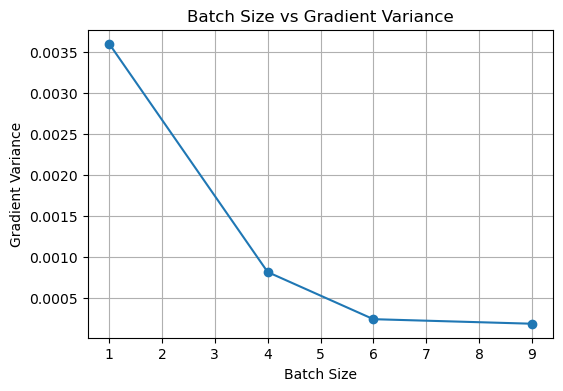

In [11]:
batch_sizes = [1,4,6,9]
variances = [grad_variance(b) for b in batch_sizes]
plt.figure(figsize=(6,4))
plt.plot(batch_sizes, variances, marker='o')
plt.xlabel("Batch Size"); plt.ylabel("Gradient Variance")
plt.title("Batch Size vs Gradient Variance"); plt.grid(True); plt.show()

**Reflection Q4**: 

Describe how gradient variance changes with batch size and what that means for convergence stability.

## **Summary**

| Batch Size | Gradient Variance | Training Speed | Stability |
|------------|-------------------|----------------|-----------|
| 1          | High | Fast | Noisy |
| 4 | Medium | Balanced | Smooth |
| 6 | Low | Slow | Stable |
| 9 | Lowest | Slowest | Most Stable |



---


### **Reflection (Addendum): Why `optimizer.zero_grad()` Appears Only in `train_mlp`**

This distinction highlights two fundamentally different computational roles:  
**training** vs. **gradient diagnostics**.

| Function | Purpose | Gradient Lifecycle | Need `optimizer.zero_grad()`? |
|-----------|----------|--------------------|-------------------------------|
| **`train_mlp`** | Learn model parameters | Gradients accumulate in `.grad` buffers of parameters across batches | ✅ **Yes** — to reset old gradients before new backward pass |
| **`grad_variance`** | Measure gradient noise | Gradients are computed ad-hoc via `torch.autograd.grad()` and never stored | ❌ **No** — nothing accumulates or updates |


**Key idea:**  

- **During training, PyTorch’s `optimizer.step()` uses the gradients stored in each parameter’s `.grad` field.**  

  **If you don’t clear them first, they will `add up`, corrupting the next update.**  

- **In diagnostic routines (like `grad_variance`), we only *inspect* gradients.** 

  **The call to `torch.autograd.grad(loss, model.parameters())` returns new tensors each time, leaving the model untouched — no accumulation occurs.**

**Pedagogical takeaway:**  
> **`optimizer.zero_grad()`** belongs to the *learning loop*,  
> not to *gradient measurement*.  
> This distinction clarifies how PyTorch manages state between forward-backward-update cycles.

---